In [ ]:
!pip install timm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import time
import seaborn as sns
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn
from tqdm import tqdm
import random
import moviepy.editor as mp
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device =>", device)

Device => cuda


In [ ]:
!cp -r /content/drive/MyDrive/BBM416-TermProject/datasets /content/datasets

In [ ]:
# Create a new directory named 'train_test' in the '/content' directory.
os.mkdir("/content/train_test")
# Open a file named 'classIdx.txt' in write mode inside the '/content/train_test' directory.
# The 'with' statement ensures that the file is properly closed after its suite finishes.
with open("/content/train_test/classIdx.txt", "w") as file:
    # Write the class index and name for the 'NonViolence' class to the file.
    file.write("0 NonViolence\n")
    # Write the class index and name for the 'Violence' class to the file.
    file.write("1 Violence")

In [ ]:
#This function saves video paths and labels to separate text files based on class.
def dataset_path_saver_to_txt(dataset_path, output_class1_file, output_class2_file):
    with open(output_class1_file, 'w') as f1:
        with open(output_class2_file, 'w') as f2:
          for classes in os.listdir(dataset_path):
            video_files = os.listdir(f"{dataset_path}/{classes}")
            for video_file in video_files:
              if video_file[-1:] == "4":
                if classes == "NonViolence":
                    f1.write(f"{classes}/{video_file} 0\n")
                else:
                    f2.write(f"{classes}/{video_file} 1\n")

dataset_path_saver_to_txt('/content/datasets', '/content/input1.txt', '/content/input2.txt')

#This function splits lines from two text files into training and testing sets.
def txt_line_splitter(txt1_file , txt2_file, train_output_file, test_output_file, ratio=0.8):
    with open(txt1_file, 'r') as f1:
        with open(txt2_file, 'r') as f2:
            lines1 = f1.readlines()
            lines2 = f2.readlines()
            random.shuffle(lines1)
            random.shuffle(lines2)
            length1 = int(len(lines1))
            length2 = int(len(lines2))
            for i in range(length1):
                if i < ratio*length1:
                    with open(train_output_file, 'a') as f:
                        f.write(lines1[i])
                else:
                    with open(test_output_file, 'a') as f:
                        f.write(lines1[i])
            for i in range(length2):
                if i < ratio*length2:
                    with open(train_output_file, 'a') as f:
                        f.write(lines2[i])
                else:
                    with open(test_output_file, 'a') as f:
                        f.write(lines2[i])

txt_line_splitter('/content/input1.txt', '/content/input2.txt', '/content/train_test/train.txt', '/content/train_test/test.txt')
#This function shuffles the lines in a text file.
def txt_line_shuffler(txt_file):
    with open(txt_file, 'r') as f:
        lines = f.readlines()
        random.shuffle(lines)
        with open(txt_file, 'w') as f:
            for line in lines:
                f.write(line)

txt_line_shuffler('/content/train_test/train.txt')
txt_line_shuffler('/content/train_test/test.txt')
os.remove('/content/input1.txt')
os.remove('/content/input2.txt')

In [ ]:
with open('/content/train_test/train.txt', 'r') as f1:
  print("Number of Train Videos: ", len(f1.readlines()))
with open('/content/train_test/test.txt', 'r') as f1:
  print("Number of Test Videos: ", len(f1.readlines()))

Number of Train Videos:  1559
Number of Test Videos:  389


In [ ]:
class VideoDataset(torch.utils.data.Dataset):
  """
  This class defines a custom dataset for video classification tasks.

  Args:
      video_dir (str): Path to the directory containing video files.
      trainTest_dir (str): Path to the directory containing training/testing text files.
      classesIdx_txt (str): Path to the text file containing class labels.
      mode (str, optional): Mode ('train' or 'test') indicating training or testing data (default: 'train').
      num_classes (int, optional): Number of classes in the dataset (default: 5).
      num_frames (int, optional): Number of frames to sample from each video (default: 50).
      transform (torchvision.transforms, optional): Transformation to apply to each frame (default: None).
      target_transform (torchvision.transforms, optional): Transformation to apply to labels (default: None).
  """
    def __init__(self, video_dir, trainTest_dir, classesIdx_txt, mode = 'train', num_classes = 5,
                     num_frames = 50, transform = None, target_transform = None):
        super().__init__()

        self.video_dir = video_dir
        self.trainTest_dir = trainTest_dir
        self.classIndx_txt = classesIdx_txt
        self.mode = mode.strip().lower()

        assert self.mode in ['train', 'test']

        self.transform = transform
        self.target_transform = target_transform
        self.num_classes = num_classes

        self.num_frames = num_frames

        self.class_dict = {}
        with open(self.classIndx_txt, 'r') as f:
            for line in f.readlines():
                classIdx, classLabel = line.split()
                self.class_dict[int(classIdx)] = classLabel

        self.video_filename_list = []
        self.classesIdx_list = []

        for trainTest_filename in os.listdir(self.trainTest_dir):
            if self.mode in trainTest_filename:
                path_txt = os.path.join(self.trainTest_dir, trainTest_filename)
                video_filename, classesIdx = self.read_traintest_txt(path_txt)
                self.video_filename_list = self.video_filename_list + video_filename
                self.classesIdx_list = self.classesIdx_list + classesIdx

    def __len__(self):
    """
    Returns the length of the dataset (number of video samples).
    """
        return len(self.video_filename_list)

    def read_traintest_txt(self, path):
    """
    Reads training/testing text file and returns a list of video filenames and corresponding class indices.

    Args:
        path (str): Path to the training/testing text file.

    Returns:
        tuple: (list of video filenames, list of class indices)
    """
        video_filename = []
        classIdx = []
        with open(path, 'r') as f:
            for line in f.readlines():
                if self.mode == 'train':
                    filename, Idx = line.split()
                    if int(Idx) < self.num_classes:
                        video_filename.append(filename)
                        classIdx.append(int(Idx))
                elif self.mode == 'test':
                    filename, Idx = line.split()
                    if int(Idx) < self.num_classes:
                        video_filename.append(filename)
                        classIdx.append(int(Idx))

        return video_filename, classIdx

    def read_video(self, video_path):
    """
    Reads a video and samples a specified number of frames with equal stride.

    Args:
        video_path (str): Path to the video file.

    Returns:
        torch.Tensor: Stacked tensor of sampled frames (shape: [num_frames, channels, height, width])
    """
        frames = []
        cap = cv.VideoCapture(video_path)
        count_frames = 0
        while True:
            ret, frame = cap.read()
            if ret:
                if self.transform:
                    transformed = self.transform(image = frame)
                    frame = transformed['image']

                frames.append(frame)
                count_frames += 1
            else:
                break

        stride = count_frames // self.num_frames
        if stride <= 0:
          print(video_path)
          print(stride)
          print(count_frames)
          print(self.num_frames)
        new_frames = []
        count = 0
        for i in range(0, count_frames, stride):
            if count >= self.num_frames:
                break
            new_frames.append(frames[i])
            count += 1

        cap.release()

        return torch.stack(new_frames, dim = 0)

    def __getitem__(self, idx):
        classIdx = self.classesIdx_list[idx]
        classLabel = self.class_dict[classIdx]
        video_filename = self.video_filename_list[idx]
        video_path = os.path.join(self.video_dir, video_filename)

        frames = self.read_video(video_path)

        return frames, classIdx

In [ ]:
def split_dataloader(train_data, validation_split = 0.2):
"""
  Splits a DataLoader object into separate training and validation Dataloaders.

  Args:
      train_data (torch.utils.data.DataLoader): The original DataLoader object containing the entire dataset.
      validation_split (float, optional): Proportion of the data to use for validation (default: 0.2).

  Returns:
      tuple: (train_data, val_data): A tuple containing the new training and validation Dataloaders.
"""
    train_ratio = 1 - validation_split
    train_size = int(train_ratio * len(train_data.dataset))
# Create lists of indices for training and validation splits
    indices = list(range(len(train_data.dataset)))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
# Extract parameters from the original DataLoader
    dataset = train_data.dataset
    batch_size = train_data.batch_size
    num_workers = train_data.num_workers
# Create SubsetRandomSamplers for training and validation sets
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
# Create new Dataloaders for training and validation sets using the split indices and original parameters
    train_data = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers, drop_last = True)
    val_data = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = val_sampler, num_workers = num_workers, drop_last = True)

    return train_data, val_data

In [ ]:
def evaluate(model, val_data, loss_fn, weights = None, device = 'cpu', verbose = 0):
"""
  Evaluates a model on a validation dataset.

  Args:
      model (torch.nn.Module): The model to be evaluated.
      val_data (torch.utils.data.DataLoader): The validation data loader.
      loss_fn (torch.nn.functional): The loss function for calculating loss.
      weights (str, optional): Path to weights file for loading pre-trained weights (default: None).
      device (str, optional): Device to use for evaluation ('cpu' or 'cuda' if available) (default: 'cpu').
      verbose (int, optional): Verbosity level (0: silent, 1: progress bar) (default: 0).

  Returns:
      tuple: (validation loss, validation accuracy)
 """
 # Handle device selection (CPU or GPU)
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device):
        device = device
    else:
        device = torch.device('cpu')
# Move the model to the chosen device
    model = model.to(device)
# Load pre-trained weights if provided
    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')
# Disable gradient calculation for efficiency during evaluation
    with torch.no_grad():
        model.eval()
        # Initialize variables for tracking performance
        val_correct = 0
        val_total = len(val_data)*val_data.batch_size
        running_loss = 0.
        # Use tqdm progress bar for verbosity level 1
        if verbose == 1:
            val_data = tqdm(val_data, desc = 'Evaluate: ', ncols = 100)
        # Loop through the validation data in batches
        for data_batch, label_batch in val_data:
            data_batch, label_batch = data_batch.to(device), label_batch.to(device)
            # Forward pass through the model
            output_batch = model(data_batch).reshape(-1)
            # Calculate batch loss
            loss = loss_fn(output_batch, label_batch.float())
            running_loss += loss.item()
            # Update total correct predictions
            val_correct += (label_batch == output_batch.data.round()).sum().item()
        # Calculate overall validation loss and accuracy
        val_loss = running_loss/len(val_data)
        val_acc = val_correct/val_total

        return val_loss, val_acc

In [ ]:
class EarlyStopper:
"""
  This class implements Early Stopping for training a model.

  Early stopping helps prevent overfitting by stopping training when the validation loss
  stops improving for a certain number of epochs (patience).
"""
    def __init__(self, patience=1, min_delta=0):
    """
    Initializes the EarlyStopper object.

    Args:
        patience (int, optional): Number of epochs to wait for improvement in validation loss before stopping (default: 1).
        min_delta (float, optional): Minimum change in validation loss to consider an improvement (default: 0).
    """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):

    """
    Checks if early stopping conditions are met based on the current validation loss.

    Args:
        validation_loss (float): The current validation loss.

    Returns:
        bool: True if early stopping should be triggered, False otherwise.
    """
        if validation_loss < self.min_validation_loss:
          # Update minimum validation loss if current loss is lower
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
          # Increment counter if validation loss doesn't improve sufficiently
            self.counter += 1
            if self.counter >= self.patience:
              # Early stopping condition met if counter reaches patience limit
                return True
        return False

In [ ]:
def train(model, train_data, loss_fn, optimizer, epochs, weights = None, save_last_weights_path = None,
          save_best_weights_path = None, freeze = False, steps_per_epoch = None,
          device = 'cpu', validation_data = None, validation_split = None, scheduler = None, patience = 3):
"""
  Trains a model on a given dataset.

  Args:
      model (torch.nn.Module): The model to be trained.
      train_data (torch.utils.data.DataLoader): The training data loader.
      loss_fn (torch.nn.functional): The loss function for calculating loss.
      optimizer (torch.optim): The optimizer to be used for updating model weights.
      epochs (int): Number of training epochs.
      weights (str, optional): Path to weights file for loading pre-trained weights (default: None).
      save_last_weights_path (str, optional): Path to save the model weights after training (default: None).
      save_best_weights_path (str, optional): Path to save the model weights with the best validation performance (default: None).
      freeze (bool, optional): Whether to freeze the weights of certain layers during training (default: False).
      steps_per_epoch (int, optional): Number of training steps per epoch (default: None - Uses entire train data).
      device (str, optional): Device to use for training ('cpu' or 'cuda' if available) (default: 'cpu').
      validation_data (torch.utils.data.DataLoader, optional): The validation data loader (default: None).
      validation_split (float, optional): Proportion of training data to use for validation (default: None - requires validation_data).
      scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler (default: None).
      patience (int, optional): Number of epochs to wait for improvement in validation loss before stopping early (default: 3).

  Returns:
      tuple: (trained model, training history)

  Raises:
      AssertionError: If both validation_data and validation_split are provided.
"""
# Assert that validation data and validation split are not both provided
    assert not(validation_data is not None and validation_split is not None)
# Initialize Early Stopper object for early stopping
    early_stopper = EarlyStopper(patience=patience, min_delta=0)
# Load pre-trained weights if provided
    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')
# Handle device selection (CPU or GPU)
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device):
        device = device
    else:
        device = torch.device('cpu')
# Determine validation data based on provided options
    if validation_data is not None:
        val_data = validation_data
    elif validation_split is not None:
        train_data, val_data = split_dataloader(train_data, validation_split)
    else:
        val_data = None
# Initialize containers for best validation loss and training history
    if save_best_weights_path:
        if val_data is None:
            train_data, val_data = split_dataloader(train_data, 0.2)
        best_loss, _ = evaluate(model, val_data, device = device, loss_fn = loss_fn)
# Determine steps per epoch if not provided
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
# Get total number of steps and training data iterator
    num_steps = len(train_data)
    iterator = iter(train_data)
    count_steps = 1
# Initialize training history dictionary
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_loss': []
    }
# Move the model to the chosen device
    model = model.to(device)

    ############################### Train and Val ##########################################
    for epoch in range(1, epochs + 1):
        # Initialize epoch variables
        running_loss = 0.
        train_correct = 0
        train_total = steps_per_epoch*train_data.batch_size
        # Set model to train mode
        model.train()
        # Training loop per epoch
        for step in tqdm(range(steps_per_epoch), desc = f'epoch: {epoch}/{epochs}: ', ncols = 100):
            # Get training data mini-batch
            img_batch, label_batch = next(iterator)
            # Move data and labels to chosen device
            img_batch, label_batch = img_batch.to(device), label_batch.to(device)
            # Clear gradients from optimizer
            optimizer.zero_grad()
            # Forward pass through the model
            output_batch = model(img_batch).reshape(-1)
            # Calculate loss for the mini-batch
            loss = loss_fn(output_batch, label_batch.float())
            # Backward pass to compute gradients
            loss.backward()
            # Update model weights using optimizer
            optimizer.step()
            # Update training accuracy
            train_correct += (label_batch == output_batch.data.round()).sum().item()
            # Update running loss
            running_loss += loss.item()
            # Handle resetting data iterator at epoch end
            if count_steps == num_steps:
                count_steps = 0
                iterator = iter(train_data)
            count_steps += 1
        # Calculate average training loss and accuracy for the epoch
        train_loss = running_loss / steps_per_epoch
        train_accuracy = train_correct/train_total

        # reduce lr with scheduler if provided
        if scheduler:
            scheduler.step(train_loss)
        # Update training history
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_accuracy))
        # Validation step (if validation data provided)
        if val_data is not None:
            val_loss, val_acc = evaluate(model, val_data, device = device, loss_fn = loss_fn)
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}, val_accuracy: {val_acc: .2f}, val_loss: {val_loss:.3f}')
            # Save best model weights based on validation loss
            if save_best_weights_path:
                if val_loss < best_loss:
                    best_loss = val_loss
                    torch.save(model.state_dict(), save_best_weights_path)
                    print(f'Saved successfully best weights to:', save_best_weights_path)
            history['val_loss'].append(float(val_loss))
            history['val_acc'].append(float(val_acc))
        else:
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}')

        if early_stopper.early_stop(val_loss):
          print("Early Stopped!")
          break

    if save_last_weights_path:
        torch.save(model.state_dict(), save_last_weights_path)
        print(f'Saved successfully last weights to:', save_last_weights_path)
    return model, history

In [ ]:
class ClassificationModel(nn.Module):
"""
  This class defines a convolutional neural network (CNN) architecture with an LSTM layer
  for video classification tasks.

  Args:
      num_classes (int): Number of output class labels.
      hidden_size (int): Size of the hidden state in the LSTM layer.
      num_lstm_layers (int, optional): Number of stacked LSTM layers (default: 2).
      backbone_name (str, optional): Name of the pre-trained backbone CNN model (default: 'resnet101').
"""
    def __init__(self, num_classes, hidden_size, num_lstm_layers = 2, backbone_name = 'resnet101'):
    """
    Initializes the ClassificationModel with the specified parameters.

    Args:
        num_classes (int): Number of output class labels.
        hidden_size (int): Size of the hidden state in the LSTM layer.
        num_lstm_layers (int, optional): Number of stacked LSTM layers (default: 2).
        backbone_name (str, optional): Name of the pre-trained backbone CNN model (default: 'resnet101').
    """
        super().__init__()
        # Define the pre-trained backbone CNN for feature extraction
        self.backbone = timm.create_model(backbone_name, pretrained = True, features_only = True)
        # Adaptive Average Pooling layer to reduce feature map size
        self.adap = nn.AdaptiveAvgPool2d((2,2))
        # Define the LSTM layer for processing sequences of features
        self.lstm = nn.LSTM(2048, hidden_size, num_lstm_layers, batch_first = True)
        # Final fully-connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes-1)

    def forward(self, x):
    """
    Defines the forward pass of the model for a given input video tensor.

    Args:
        x (torch.Tensor): Input video tensor with shape (batch, num_frames, channels, height, width).

    Returns:
        torch.Tensor: Output logits with shape (batch, num_classes).
    """
        'x: batch, num_frames, channels, height, width'

        batch, num_frames, channels, height, width = x.shape
        # Reshape the input to remove the num_frames dimension initially (for processing individual frames)
        x = torch.reshape(x, (-1, *x.shape[2:]))
        # Pass the frames through the pre-trained backbone CNN to extract features

        x1,x2,x3,x4,x5 = self.backbone(x)
        # Use AdaptiveAvgPool2d to reduce feature map size to a fixed size
        x = self.adap(x3)
        # Flatten the features from a 4D tensor to a 2D tensor
        x = nn.Flatten()(x)
        # Reshape the features back to consider the sequence dimension (num_frames)
        x = torch.reshape(x, (batch, num_frames, -1))
        # Pass the sequence of features through the LSTM layers
        x, (h_n, c_n) = self.lstm(x)
        # Use the hidden state of the last LSTM layer for classification
        x = h_n[-1, ...]
        # Apply a fully-connected layer to get logits for each class
        x = self.fc(x)
        # Apply sigmoid activation for probability-like outputs (optional depending on task)
        x = torch.sigmoid(x)

        return x

In [ ]:
def visualize_history(history, metrics = ['acc', 'loss']):

    if 'acc' in metrics:
        plt.figure(figsize = (10,6))
        plt.subplot(121)
        plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], label = 'train_acc', c = 'r')
        plt.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label = 'val_acc', c = 'g')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    if 'loss' in metrics:
        plt.subplot(122)
        plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label = 'train_loss', c = 'r')
        plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label = 'val_loss', c = 'g')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

In [ ]:
classesIdx = '/content/train_test/classIdx.txt'
trainTest_dir = '/content/train_test'
mode = 'train'
video_dir = '/content/datasets'
last_weights = '/content/drive/MyDrive/BBM416-TermProject/binaryclass_classification/last_weights.pt'
best_weights = '/content/drive/MyDrive/BBM416-TermProject/binaryclass_classification/best_weights.pt'

patience = 3
num_classes = 2
batch_size = 32
test_batch_size = 1
num_frames = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = (224,224)
num_workers = 0
hidden_size = 128
num_lstm_layers = 2

In [ ]:
transform = A.Compose(
    [
        A.Resize(height = img_size[0], width = img_size[1]),
        A.Normalize(),
        ToTensorV2()
    ]
)

train_dataset = VideoDataset(video_dir, trainTest_dir, classesIdx, mode = 'train', num_frames = num_frames, num_classes = num_classes, transform = transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = batch_size, drop_last = True, num_workers = num_workers)

In [ ]:
# Define the Classification Model
model = ClassificationModel(num_classes = num_classes, hidden_size = hidden_size,
                            num_lstm_layers = num_lstm_layers, backbone_name = 'resnet101')
# Define the Loss Function
loss_fn = nn.BCELoss()
# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
# Define the Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, mode = 'min', patience = patience, verbose = 1)

In [ ]:
model, history = train(model, train_dataloader, loss_fn, optimizer, weights = None, epochs = 20,
              save_last_weights_path = last_weights, save_best_weights_path = best_weights,
              device = device, validation_split = 0.2, steps_per_epoch = 100, scheduler = scheduler, patience = patience)

epoch: 1/20: 100%|████████████████████████████████████████████████| 100/100 [08:28<00:00,  5.08s/it]


epoch: 1, train_accuracy:  0.64, loss:  0.680, val_accuracy:  0.73, val_loss: 0.663
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 2/20: 100%|████████████████████████████████████████████████| 100/100 [08:23<00:00,  5.03s/it]


epoch: 2, train_accuracy:  0.77, loss:  0.645, val_accuracy:  0.81, val_loss: 0.619
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 3/20: 100%|████████████████████████████████████████████████| 100/100 [08:17<00:00,  4.97s/it]


epoch: 3, train_accuracy:  0.80, loss:  0.591, val_accuracy:  0.81, val_loss: 0.552
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 4/20: 100%|████████████████████████████████████████████████| 100/100 [08:37<00:00,  5.18s/it]


epoch: 4, train_accuracy:  0.83, loss:  0.509, val_accuracy:  0.85, val_loss: 0.464
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 5/20: 100%|████████████████████████████████████████████████| 100/100 [08:32<00:00,  5.12s/it]


epoch: 5, train_accuracy:  0.86, loss:  0.423, val_accuracy:  0.87, val_loss: 0.385
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 6/20: 100%|████████████████████████████████████████████████| 100/100 [08:23<00:00,  5.04s/it]


epoch: 6, train_accuracy:  0.88, loss:  0.350, val_accuracy:  0.89, val_loss: 0.335
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 7/20: 100%|████████████████████████████████████████████████| 100/100 [08:23<00:00,  5.03s/it]


epoch: 7, train_accuracy:  0.90, loss:  0.292, val_accuracy:  0.91, val_loss: 0.285
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 8/20: 100%|████████████████████████████████████████████████| 100/100 [08:29<00:00,  5.10s/it]


epoch: 8, train_accuracy:  0.92, loss:  0.240, val_accuracy:  0.92, val_loss: 0.255
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 9/20: 100%|████████████████████████████████████████████████| 100/100 [08:21<00:00,  5.01s/it]


epoch: 9, train_accuracy:  0.93, loss:  0.212, val_accuracy:  0.91, val_loss: 0.242
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 10/20: 100%|███████████████████████████████████████████████| 100/100 [08:33<00:00,  5.14s/it]


epoch: 10, train_accuracy:  0.94, loss:  0.189, val_accuracy:  0.92, val_loss: 0.246


epoch: 11/20: 100%|███████████████████████████████████████████████| 100/100 [08:31<00:00,  5.11s/it]


epoch: 11, train_accuracy:  0.95, loss:  0.168, val_accuracy:  0.92, val_loss: 0.204
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 12/20: 100%|███████████████████████████████████████████████| 100/100 [08:20<00:00,  5.00s/it]


epoch: 12, train_accuracy:  0.95, loss:  0.149, val_accuracy:  0.93, val_loss: 0.203
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 13/20: 100%|███████████████████████████████████████████████| 100/100 [08:31<00:00,  5.11s/it]


epoch: 13, train_accuracy:  0.95, loss:  0.144, val_accuracy:  0.93, val_loss: 0.192
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 14/20: 100%|███████████████████████████████████████████████| 100/100 [08:31<00:00,  5.12s/it]


epoch: 14, train_accuracy:  0.97, loss:  0.119, val_accuracy:  0.94, val_loss: 0.173
Saved successfully best weights to: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


epoch: 15/20: 100%|███████████████████████████████████████████████| 100/100 [08:20<00:00,  5.00s/it]


epoch: 15, train_accuracy:  0.97, loss:  0.120, val_accuracy:  0.94, val_loss: 0.173


epoch: 16/20: 100%|███████████████████████████████████████████████| 100/100 [08:32<00:00,  5.12s/it]


epoch: 16, train_accuracy:  0.97, loss:  0.103, val_accuracy:  0.93, val_loss: 0.193


epoch: 17/20: 100%|███████████████████████████████████████████████| 100/100 [08:25<00:00,  5.05s/it]


epoch: 17, train_accuracy:  0.97, loss:  0.097, val_accuracy:  0.93, val_loss: 0.189
Early Stopped!
Saved successfully last weights to: /content/drive/MyDrive/416Project/binaryclass_classification/last_weights.pt


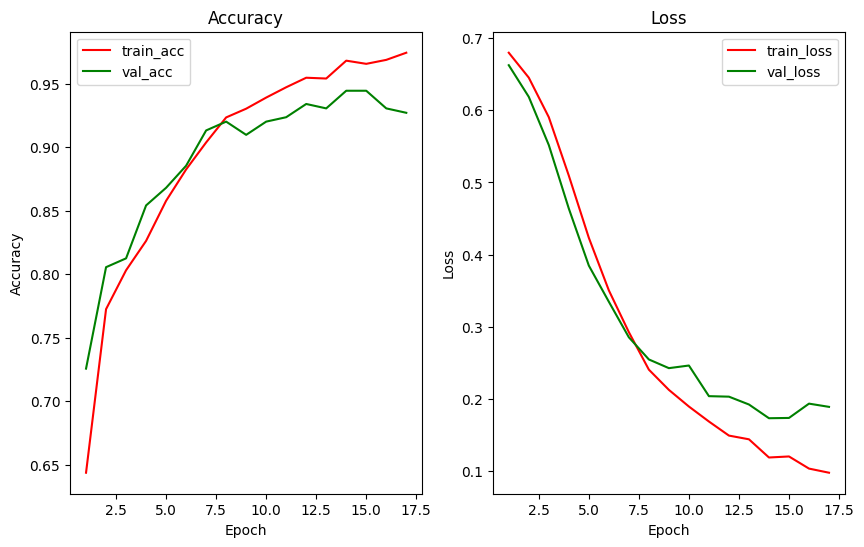

In [ ]:
visualize_history(history)

## TEST PART

In [ ]:
def evaluate_test(model, val_data, loss_fn, weights = None, device = 'cpu', verbose = 0):
"""
  Evaluates the performance of a model on a given validation or test dataset.

  Args:
      model (torch.nn.Module): The model to be evaluated.
      val_data (torch.utils.data.DataLoader): The data loader for the validation/test data.
      loss_fn (torch.nn.functional): The loss function for calculating loss.
      weights (str, optional): Path to a pre-trained weights file (default: None).
      device (str, optional): Device to use for evaluation ('cpu' or 'cuda' if available) (default: 'cpu').
      verbose (int, optional): Controls verbosity level (0: silent, 1: progress bar) (default: 0).

  Returns:
      tuple: (validation loss, validation accuracy, ground truth labels, predicted labels)
"""
    # set device
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device):
        device = device
    else:
        device = torch.device('cpu')

    model = model.to(device)
# Load pre-trained weights if provided
    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')
# Disable gradient calculation for efficiency during evaluation
    with torch.no_grad():
        outputs = list()
        labels = list()
        model.eval()
        val_correct = 0
        val_total = len(val_data)*val_data.batch_size
        running_loss = 0.
        if verbose == 1:
            val_data = tqdm(val_data, desc = 'Evaluate: ', ncols = 100)
        for data, label in val_data:
            data, label = data.to(device), label.to(device)

            output = model(data).reshape(-1)

            outputs.append(int(output.data.round().item()))
            labels.append(label.item())

            loss = loss_fn(output, label.float())
            running_loss += loss.item()

            val_correct += (label == output.data.round()).sum().item()
        val_loss = running_loss/len(val_data)
        val_acc = val_correct/val_total
# Return evaluation metrics and predicted/true labels
        return val_loss, val_acc, labels, outputs

In [ ]:
# Define data transformation pipeline
transform = A.Compose(
    [
        A.Resize(height = img_size[0], width = img_size[1]),
        A.Normalize(),
        ToTensorV2()
    ]
)
# Create the test video dataset
test_dataset = VideoDataset(video_dir, trainTest_dir, classesIdx, mode = 'test', num_frames = num_frames, num_classes = num_classes, transform = transform)
# Create the test data loader
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, drop_last = True, num_workers = num_workers)

In [ ]:
target_names = ["Non-Violence", "Violence"]
class_def = {0: "Non-Violence", 1: "Violence"}

In [ ]:
test_loss, test_acc, labels, predictions_best = evaluate_test(model, weights = best_weights, val_data = test_dataloader, loss_fn = loss_fn, device = 'cuda', verbose = 1)
print(f'\nLoss: {test_loss : .3f}, Acc: {test_acc: .3f}')

Weights loaded successfully from path: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


Evaluate: 100%|███████████████████████████████████████████████████| 389/389 [01:01<00:00,  6.37it/s]


Loss:  0.223, Acc:  0.915


In [ ]:
print(classification_report(labels, predictions_best, target_names=target_names))

              precision    recall  f1-score   support

Non-Violence       0.92      0.91      0.91       190
    Violence       0.92      0.92      0.92       199

    accuracy                           0.92       389
   macro avg       0.92      0.92      0.92       389
weighted avg       0.92      0.92      0.92       389



<Axes: >

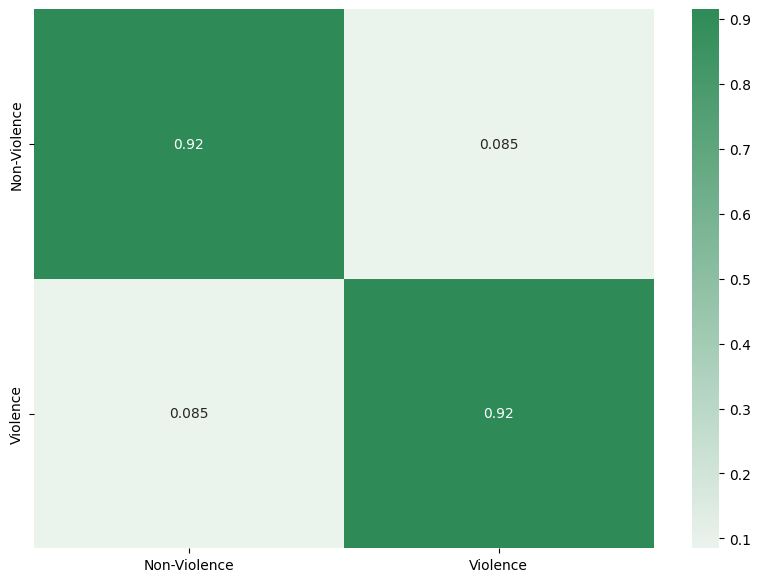

In [ ]:
# Calculate confusion matrix with normalized values per predicted class
result = confusion_matrix(labels, predictions_best , normalize='pred')
# Create confusion matrix DataFrame
df_cm = pd.DataFrame(result, index = [i for i in class_def.values()],
                  columns = [i for i in class_def.values()])

# Create a Matplotlib figure for plotting
plt.figure(figsize = (10,7))
color = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(df_cm, annot=True, cmap=color)

### Test With Random Videos

The model was tested with 20 videos more from outside of the 1000 violence and 1000 non-violence dataset to evaluate model accurately.

In [ ]:
!cp -r /content/drive/MyDrive/416Project/test-videos /content/test-videos

In [ ]:
os.mkdir("/content/test")

with open("/content/test/classIdx.txt", "w") as file:
    file.write("0 NonViolence\n")
    file.write("1 Violence")

In [ ]:
# creates a text file containing video paths and labels from a dataset directory.
def dataset_path_saver_to_txt(dataset_path, output_class1_file):
    with open(output_class1_file, 'w') as f1:
      for classes in os.listdir(dataset_path):
        video_files = os.listdir(f"{dataset_path}/{classes}")
        for video_file in video_files:
          if video_file[-1:] == "4":
            if classes == "NonViolence":
                f1.write(f"{classes}/{video_file} 0\n")
            else:
                f1.write(f"{classes}/{video_file} 1\n")

dataset_path_saver_to_txt('/content/test-videos', '/content/test/test.txt')

#shuffle the data
def txt_line_shuffler(txt_file):
    with open(txt_file, 'r') as f:
        lines = f.readlines()
        random.shuffle(lines)
        with open(txt_file, 'w') as f:
            for line in lines:
                f.write(line)

txt_line_shuffler('/content/test/test.txt')



In [ ]:
video_dir = '/content/test-videos'
test_dir = "/content/test"
classesIdx = "/content/test/classIdx.txt"
num_frames = 10
num_classes = 2
batch_size = 1
num_workers = 0
img_size = (224,224)
# Define data transformation pipeline
transform = A.Compose(
    [   # Resize images to specified dimensions
        A.Resize(height = img_size[0], width = img_size[1]),
        # Apply normalization
        A.Normalize(),
        # Convert data to PyTorch tensors
        ToTensorV2()
    ]
)
# Create a sample test dataset instance
sample_test_dataset = VideoDataset(video_dir, test_dir, classesIdx, mode = 'test', num_frames = num_frames, num_classes = num_classes, transform = transform)
# Create a sample test data loader
sample_test_dataloader = torch.utils.data.DataLoader(sample_test_dataset, batch_size = batch_size, drop_last = True, num_workers = num_workers)

In [ ]:
num_classes = 2 # Number of classes in your classification task (violence/non-violence)
hidden_size = 128 # Size of the hidden layer in the LSTM network
num_lstm_layers = 2 # Number of LSTM layers to stack in the network
# Assuming ClassificationModel is a custom class defined elsewhere
model = ClassificationModel(num_classes = num_classes, hidden_size = hidden_size,
                            num_lstm_layers = num_lstm_layers, backbone_name = 'resnet101')

In [ ]:
best_weights = '/content/drive/MyDrive/BBM416-TermProject/binaryclass_classification/best_weights.pt' # Path to the best weights for the model
# Loss function for binary classification
loss_fn = nn.BCELoss()

# Optimizer for training with Adam and learning rate 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
# Evaluate the model on the test dataset
test_loss, test_acc, labels, preds = evaluate_test(model, weights = best_weights, val_data = sample_test_dataloader, loss_fn = loss_fn, device = 'cuda', verbose = 1)
# Print test loss and accuracy
print(f'\nLoss: {test_loss : .3f}, Acc: {test_acc: .3f}')

Weights loaded successfully from path: /content/drive/MyDrive/416Project/binaryclass_classification/best_weights.pt


Evaluate: 100%|█████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.64it/s]


Loss:  0.246, Acc:  0.900


In [ ]:
print("true labels: ", labels)
print("preds labels: ", preds)

true labels:  [0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]
preds labels:  [1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]


In [ ]:
with open("/content/test/test.txt", 'r') as f:
    lines = f.readlines()
    resized_clips = list()

mp.ipython_display(os.path.join('/content/test-videos', lines[19].split(" ")[0]))